In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

datapath = os.path.join("data", "")

In [2]:
loan = pd.read_csv(datapath + "loan.csv", parse_dates=['applicationDate', 'originatedDate'])
payment = pd.read_csv(datapath + "payment.csv")
clarity = pd.read_csv(datapath + "clarity_underwriting_variables.csv")

# boolean column to int
for col in ['originated', 'approved']:
    loan[col] = loan[col].astype(int)

#### Hypotheses to be explored

##### Loan
- How many isFunded is repaid?
- Is the data balanced in relation to the interest class (loanStatus)?
- The loan amount that customer is likely to repay?
- Does date generate loan business?

##### Payment
- Does number of installments / checked payments contributes to successful repayment?

#### Issues to be addressed
- What to do with missing values.
- Techniques used with imbalanced classification problems.

### Loan

In [3]:
loan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 577682 entries, 0 to 577681
Data columns (total 19 columns):
 #   Column                            Non-Null Count   Dtype         
---  ------                            --------------   -----         
 0   loanId                            577426 non-null  object        
 1   anon_ssn                          577682 non-null  object        
 2   payFrequency                      576409 non-null  object        
 3   apr                               573760 non-null  float64       
 4   applicationDate                   577682 non-null  datetime64[ns]
 5   originated                        577682 non-null  int64         
 6   originatedDate                    46044 non-null   datetime64[ns]
 7   nPaidOff                          577658 non-null  float64       
 8   approved                          577682 non-null  int64         
 9   isFunded                          577682 non-null  int64         
 10  loanStatus                      

In [4]:
loan.describe()

,apr,originated,nPaidOff,approved,isFunded,loanAmount,originallyScheduledPaymentAmount,leadCost,hasCF
count,573760.000000,577682.000000,577658.000000,577682.000000,577682.000000,575432.000000,577682.000000,577682.000000,577682.000000
mean,553.080972,0.079639,0.037887,0.069305,0.067480,514.245084,1428.897209,7.854389,0.619187
std,110.046159,0.270734,0.333366,0.253972,0.250852,320.939929,925.009141,12.853451,0.485587
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-816.710000,0.000000,0.000000
25%,490.000000,0.000000,0.000000,0.000000,0.000000,350.000000,1023.640000,3.000000,0.000000
50%,590.000000,0.000000,0.000000,0.000000,0.000000,500.000000,1245.250000,3.000000,1.000000
75%,601.000000,0.000000,0.000000,0.000000,0.000000,500.000000,1615.660000,6.000000,1.000000
max,705.590000,1.000000,21.000000,1.000000,1.000000,5000.000000,19963.630000,200.000000,1.000000


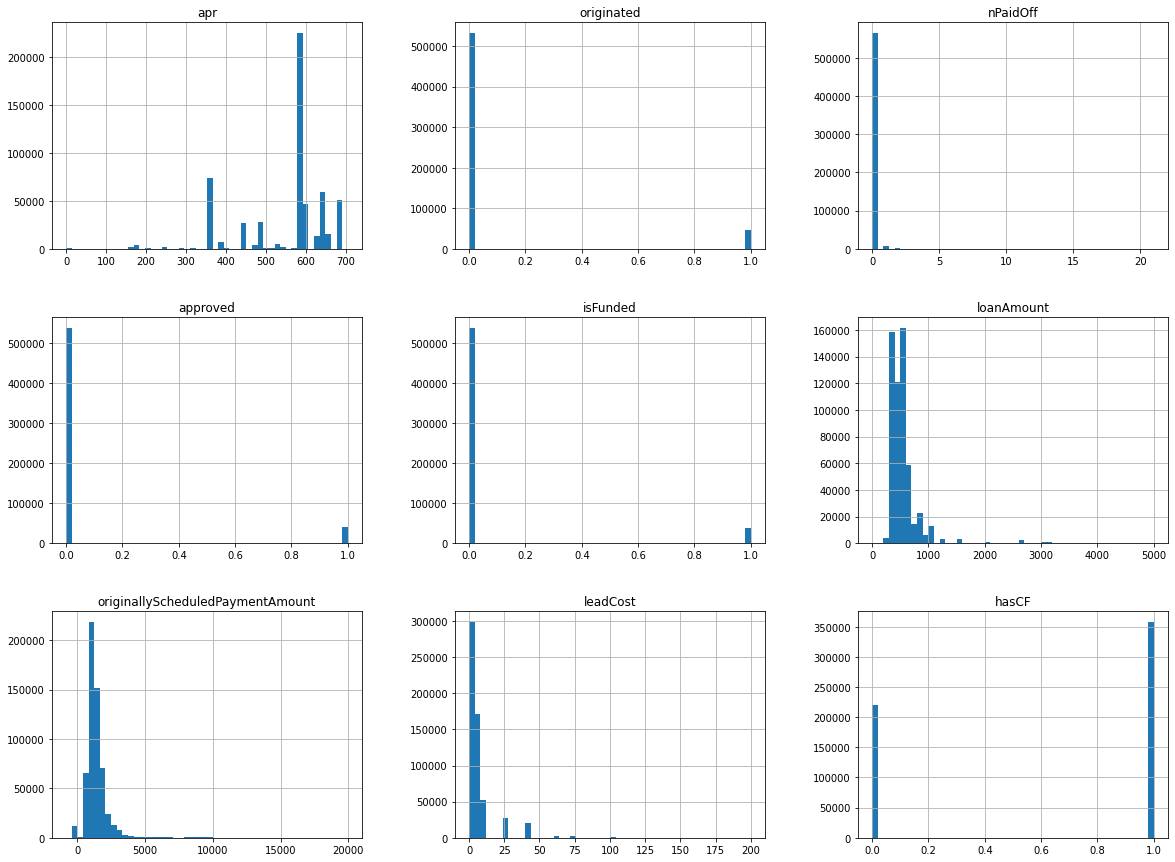

In [5]:
loan.hist(bins=50, figsize=(20,15))
plt.show()

`originated`, `nPaidOff`, `approved`, `isFunded` are imbalanced with more 0s. No outliers detected.

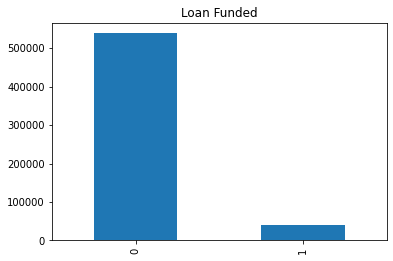

In [6]:
loan.isFunded.value_counts().plot.bar()
plt.title("Loan Funded")
plt.show()

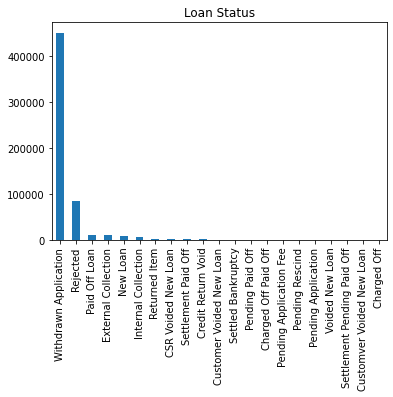

In [7]:
loan.loanStatus.value_counts().plot.bar()
plt.title('Loan Status')
plt.show()

Most loans were withdrawn or rejected. Target class Paid Off Loan is little.

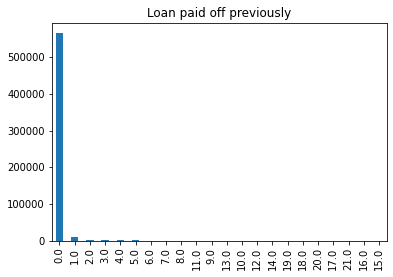

In [8]:
loan.nPaidOff.value_counts().plot.bar()
plt.title('Loan paid off previously')
plt.show()

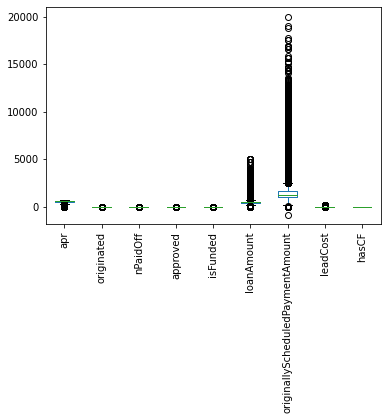

In [9]:
loan.plot.box(rot=90)
plt.show()

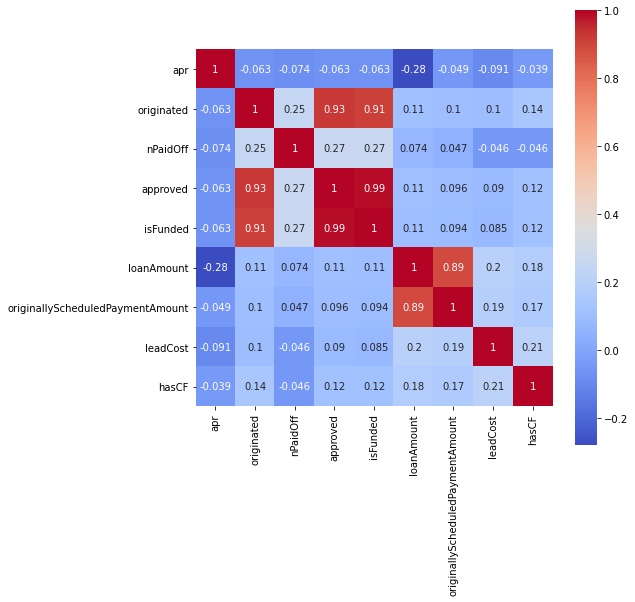

In [10]:
plt.figure(figsize=(8,8))
sns.heatmap(loan.corr(), annot=True, cmap='coolwarm', square=True)
plt.show()

High correlation among:
- approved, originated and isFunded
- loanAmount, originallyScheduledPaymentAmount

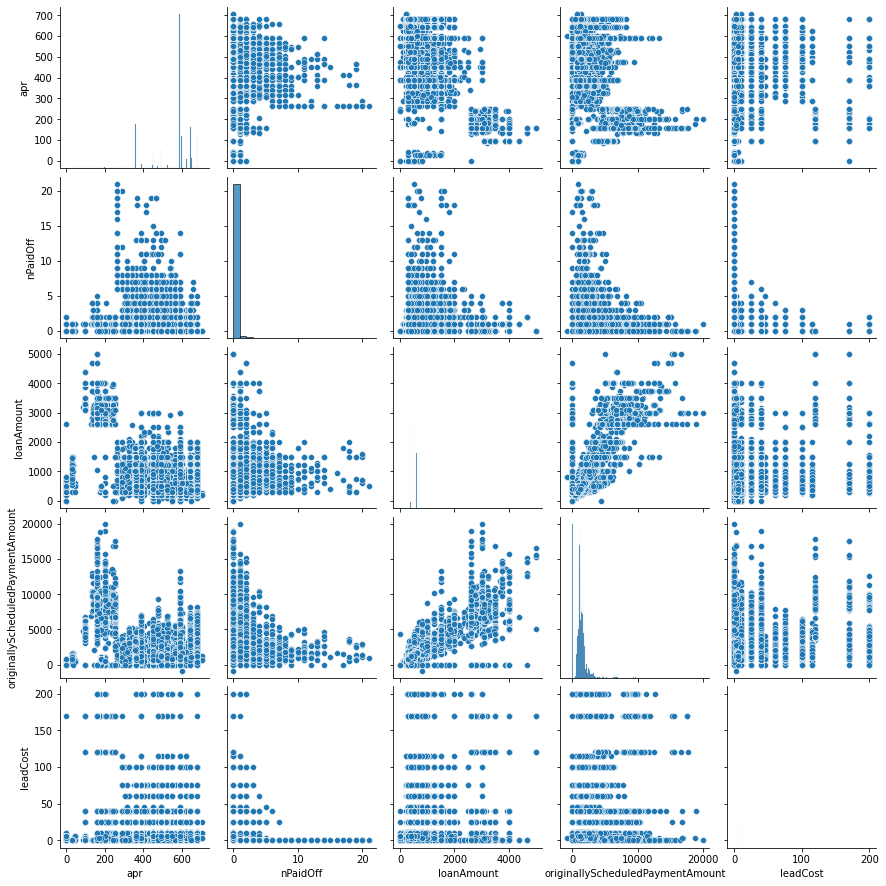

In [11]:
sns.pairplot(loan.drop(['approved', 'originated', 'isFunded', 'hasCF'], axis=1))
plt.show()

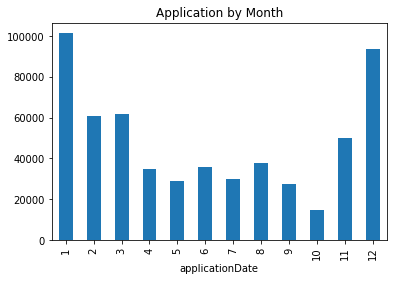

In [12]:
loan['loanId'].groupby(loan["applicationDate"].dt.month).size().plot.bar()
plt.title('Application by Month')
plt.show()

More loan businesses at beginning and end of year.

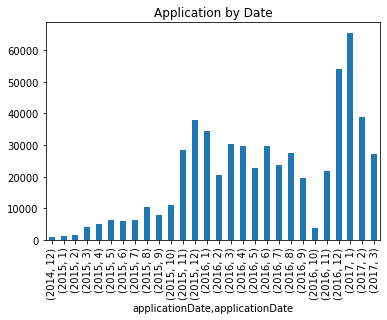

In [13]:
loan['loanAmount'].groupby([loan["applicationDate"].dt.year, loan["applicationDate"].dt.month]).count().plot.bar()
plt.title('Application by Date')
plt.show()

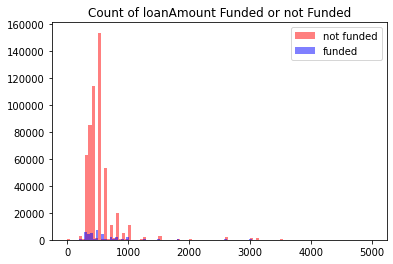

In [14]:
x1 = loan[loan['isFunded'] == 1]['loanAmount']
x2 = loan[loan['isFunded'] == 0]['loanAmount']

plt.hist(x2, bins=100, color='r', alpha=0.5, label="not funded")
plt.hist(x1, bins=100, color='b', alpha=0.5, label="funded")
plt.legend()
plt.title('Count of loanAmount Funded or not Funded')
plt.show()

Most loans are not funded as shown in red.

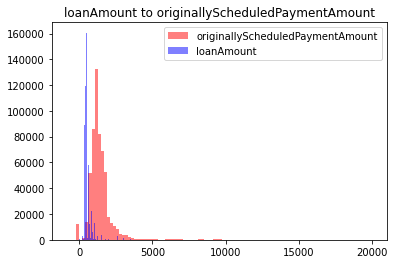

In [15]:
x1 = loan['loanAmount']
x2 = loan['originallyScheduledPaymentAmount']

plt.hist(x2, bins=100, color='r', alpha=0.5, label="originallyScheduledPaymentAmount")
plt.hist(x1, bins=100, color='b', alpha=0.5, label="loanAmount")
plt.legend()
plt.title('loanAmount to originallyScheduledPaymentAmount')
plt.show()

##### Encoding

Using data for funded applications only.

Categorise `loanStatus` and `fpStatus` into 1 and 0.
- `loanStatus` is 1 when `Paid Off Loan` or `Paid Off Settlement`
 - `loanStatus` still pending is ignored
 - `loanStatus` charged off is 0
- `fpStatus` is 1 when the value is `Checked`

In [16]:
for col in ['payFrequency', 'loanStatus']:
    loan[col] = loan[col].astype('category')
    
loan_mod = loan[loan['isFunded'] == 1]
loan_mod['loanStatus'] = np.where(loan_mod['loanStatus'].str.contains("Paid Off Loan|Settlement Paid Off", na=False), 1, 
                                  np.where(loan_mod['loanStatus'].str.contains("Settled Bankruptcy|Charged Off Paid Off|Charged Off", na=False), 0, np.nan))
loan_mod['fpStatus'] = np.where(loan_mod['fpStatus'].str.contains("Checked",  na=False), 1, 0)
loan_mod = loan_mod.dropna(subset=['loanStatus'])
loan_mod.head()

,loanId,anon_ssn,payFrequency,apr,applicationDate,originated,originatedDate,nPaidOff,approved,isFunded,loanStatus,loanAmount,originallyScheduledPaymentAmount,state,leadType,leadCost,fpStatus,clarityFraudId,hasCF
1,LL-I-06644937,464f5d9ae4fa09ece4048d949191865c,B,199.0,2016-01-19 22:07:36.778,1,2016-01-20 15:49:18.846,0.0,1,1,1.0,3000.0,6395.19,CA,prescreen,0,1,569eb3a3e4b096699f685d64,1
47,LL-I-16519347,bc9fa73468acf18cb968a3a6a3c4697c,S,490.0,2017-01-31 17:48:17.381,1,2017-01-31 18:00:14.520,2.0,1,1,1.0,1250.0,3313.78,MO,organic,0,1,58450a15e4b0bb9d6d7344c7,1
54,LL-I-11506719,10cefd11d41612b032fd9cd2debe32dc,B,590.0,2016-08-27 09:08:05.442,1,2016-08-29 15:05:04.014,0.0,1,1,1.0,800.0,2432.08,CA,bvMandatory,10,1,578f9346e4b0810ad5e7b72e,1
64,LL-I-09279047,1d249e27292d25e4d3b4bc142a2a4aea,W,404.1,2016-05-25 03:05:18.849,1,2016-05-25 15:11:36.260,3.0,1,1,1.0,300.0,422.64,WI,organic,0,1,56621584e4b0100e84141586,1
98,LL-I-01316580,2a10b2e04c5eec9a47a8cf5b9b81a2b8,W,590.0,2015-05-26 17:02:27.312,1,2015-05-26 18:45:48.024,0.0,1,1,1.0,300.0,896.87,MO,bvMandatory,6,0,NaN,0


Calculate the date difference between `orginatedDate` and `applicationDate`.

In [17]:
loan_mod['waitingDays'] = ((loan_mod['originatedDate'] - loan_mod['applicationDate'])/ pd.offsets.Day(1))
loan_mod['waitingDays'] = loan_mod['waitingDays'].round(decimals=2)
loan_mod['waitingDays'] = loan_mod['waitingDays'].fillna(0)

In [18]:
# extract datetime to day, month and year
loan_mod['applicationMonth'] = loan_mod['applicationDate'].dt.month
loan_mod['applicationDay'] = loan_mod['applicationDate'].dt.day
loan_mod['applicationDow'] = loan_mod['applicationDate'].dt.dayofweek
loan_mod['applicationYear'] = loan_mod['applicationDate'].dt.year
loan_mod['applicationQuarter'] = loan_mod['applicationDate'].dt.quarter

loan_mod['originatedMonth'] = loan_mod['originatedDate'].dt.month
loan_mod['originatedDay'] = loan_mod['originatedDate'].dt.day
loan_mod['originatedDow'] = loan_mod['originatedDate'].dt.dayofweek
loan_mod['originatedYear'] = loan_mod['originatedDate'].dt.year
loan_mod['originatedQuarter'] = loan_mod['originatedDate'].dt.quarter

loan_mod = loan_mod.drop(['applicationDate', 'originatedDate'], axis=1)

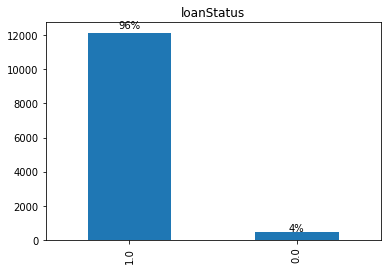

1.0    12135
0.0      485
Name: loanStatus, dtype: int64


In [19]:
total = len(loan_mod['loanStatus'])
ax = loan_mod['loanStatus'].value_counts().plot.bar()

for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy() 
    ax.annotate(f'{height/total:.0%}', (x + width/2, y + height*1.02), ha='center')
    
plt.title('loanStatus')
plt.show()
print(loan_mod['loanStatus'].value_counts())

In [20]:
x1

0          500.0
1         3000.0
2          400.0
3          500.0
4          350.0
           ...  
577677     400.0
577678    1000.0
577679     300.0
577680     300.0
577681     400.0
Name: loanAmount, Length: 577682, dtype: float64

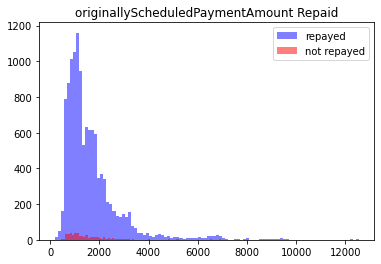

In [21]:
x1 = loan_mod[loan_mod['loanStatus'] == 1]['originallyScheduledPaymentAmount']
x2 = loan_mod[loan_mod['loanStatus'] == 0]['originallyScheduledPaymentAmount']

plt.hist(x1, bins=100, color='b', alpha=0.5, label="repayed")
plt.hist(x2, bins=100, color='r', alpha=0.5, label="not repayed")
plt.legend()
plt.title('originallyScheduledPaymentAmount Repaid')
plt.show()

Most loans are repaid. A number of loans with amount below 2000 is not repaid.

##### Imputation

In [22]:
loan_mod.isnull().sum()

loanId                                 0
anon_ssn                               0
payFrequency                           0
apr                                    0
originated                             0
nPaidOff                               7
approved                               0
isFunded                               0
loanStatus                             0
loanAmount                             0
originallyScheduledPaymentAmount       0
state                                  0
leadType                               0
leadCost                               0
fpStatus                               0
clarityFraudId                      2593
hasCF                                  0
waitingDays                            0
applicationMonth                       0
applicationDay                         0
applicationDow                         0
applicationYear                        0
applicationQuarter                     0
originatedMonth                        0
originatedDay   

In [23]:
loan_mod['nPaidOff'] = loan_mod['nPaidOff'].fillna(0)

### Payment

In [24]:
payment.head()

,loanId,installmentIndex,isCollection,paymentDate,principal,fees,paymentAmount,paymentStatus,paymentReturnCode
0,LL-I-00000021,1,False,2014-12-19T05:00:00,22.33,147.28,169.61,Checked,NaN
1,LL-I-00000021,2,False,2015-01-02T05:00:00,26.44,143.17,169.61,Checked,NaN
2,LL-I-00000021,3,False,2015-01-16T05:00:00,31.30,138.31,169.61,Checked,NaN
3,LL-I-00000021,4,False,2015-01-30T05:00:00,37.07,132.54,169.61,Checked,NaN
4,LL-I-00000021,5,False,2015-02-13T05:00:00,43.89,125.72,169.61,Checked,NaN


In [25]:
payment.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 689364 entries, 0 to 689363
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   loanId             689364 non-null  object 
 1   installmentIndex   689364 non-null  int64  
 2   isCollection       689364 non-null  bool   
 3   paymentDate        689364 non-null  object 
 4   principal          689364 non-null  float64
 5   fees               689364 non-null  float64
 6   paymentAmount      689364 non-null  float64
 7   paymentStatus      689364 non-null  object 
 8   paymentReturnCode  31533 non-null   object 
dtypes: bool(1), float64(3), int64(1), object(4)
memory usage: 42.7+ MB


In [26]:
payment.describe()

,installmentIndex,principal,fees,paymentAmount
count,689364.000000,689364.000000,689364.000000,689364.000000
mean,10.553222,45.557543,67.003994,112.680232
std,8.049530,81.724683,59.789510,105.783710
min,1.000000,-303.370000,-42.560000,-337.700000
25%,5.000000,13.180000,28.820000,56.810000
50%,9.000000,27.610000,51.300000,86.340000
75%,14.000000,53.380000,86.440000,135.090000
max,105.000000,4000.000000,1257.710000,4063.600000


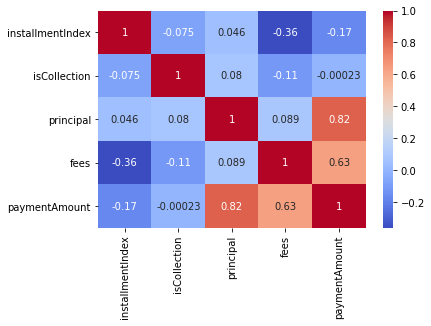

In [27]:
sns.heatmap(payment.corr(), annot=True, cmap='coolwarm')
plt.show()

`paymentAmount` is correlated with `principal` and `fees`.

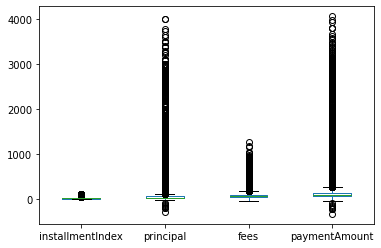

In [28]:
payment.plot.box()
plt.show()

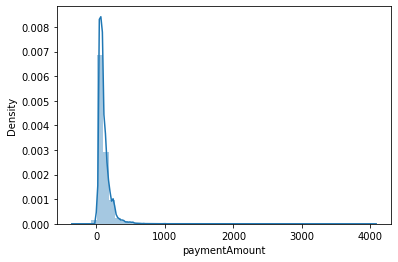

In [29]:
ax = sns.distplot(payment['paymentAmount'])
plt.show()

In [30]:
payment.groupby(["loanId"]).size()

loanId
LL-I-00000021    13
LL-I-00000231    20
LL-I-00000238    16
LL-I-00000308    22
LL-I-00000355    23
                 ..
LP-I-00000127    12
LP-I-00000134     7
LP-I-00000139    15
LP-I-00000142    13
LP-I-00000145    12
Length: 39952, dtype: int64

In [31]:
payment_mod = payment.groupby(["loanId", "paymentStatus"]).size().unstack().fillna(0)
payment_mod['installment'] = payment.groupby(["loanId"]).size() #payment.loanId.value_counts()
payment_mod['checked'] = payment.groupby(["loanId", "paymentStatus"]).size().unstack()['Checked']
payment_mod['checkedRate'] = payment_mod["checked"] / payment_mod["installment"]
payment_mod['checkedRate'] = payment_mod['checkedRate'].round(decimals=3)
payment_mod = payment_mod.fillna(0)
payment_mod = payment_mod.reset_index()
payment_mod.head()

paymentStatus,loanId,Cancelled,Checked,Complete,None,Pending,Rejected,Rejected Awaiting Retry,Returned,Skipped,installment,checked,checkedRate
0,LL-I-00000021,0.0,12.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,13,12.0,0.923
1,LL-I-00000231,8.0,2.0,0.0,8.0,0.0,2.0,0.0,0.0,0.0,20,2.0,0.100
2,LL-I-00000238,4.0,7.0,0.0,4.0,0.0,1.0,0.0,0.0,0.0,16,7.0,0.438
3,LL-I-00000308,10.0,1.0,0.0,10.0,0.0,1.0,0.0,0.0,0.0,22,1.0,0.045
4,LL-I-00000355,11.0,0.0,0.0,11.0,0.0,1.0,0.0,0.0,0.0,23,0.0,0.000


## Clarity Underwritering Variables

In [32]:
clarity.columns = clarity.columns.str.replace(r'.underwritingdataclarity.clearfraud.clearfraud', '')
clarity.head()

,inquiry.thirtydaysago,inquiry.twentyfourhoursago,inquiry.oneminuteago,inquiry.onehourago,inquiry.ninetydaysago,inquiry.sevendaysago,inquiry.tenminutesago,inquiry.fifteendaysago,inquiry.threesixtyfivedaysago,indicator.inquiryonfilecurrentaddressconflict,...,identityverification.phonematchtypedescription,identityverification.overallmatchresult,identityverification.phonetype,identityverification.ssndobreasoncode,identityverification.ssnnamereasoncode,identityverification.nameaddressreasoncode,identityverification.ssndobmatch,identityverification.overallmatchreasoncode,clearfraudscore,underwritingid
0,8.0,2.0,2.0,2.0,8.0,2.0,2.0,5.0,10.0,False,...,(M) Mobile Phone,partial,NaN,NaN,NaN,A8,match,6.0,871.0,54cbffcee4b0ba763e43144d
1,5.0,2.0,2.0,2.0,11.0,2.0,2.0,4.0,21.0,True,...,(M) Mobile Phone,partial,NaN,NaN,NaN,NaN,match,11.0,397.0,54cc0408e4b0418d9a7f78af
2,9.0,4.0,2.0,3.0,10.0,8.0,2.0,9.0,25.0,False,...,(M) Mobile Phone,match,NaN,NaN,NaN,NaN,match,1.0,572.0,54cc0683e4b0418d9a80adb6
3,3.0,2.0,2.0,2.0,9.0,2.0,2.0,2.0,9.0,False,...,(M) Mobile Phone,partial,NaN,NaN,NaN,NaN,match,11.0,838.0,54cc0780e4b0ba763e43b74a
4,5.0,5.0,2.0,2.0,6.0,5.0,2.0,5.0,6.0,False,...,(M) Mobile Phone,match,NaN,NaN,NaN,NaN,match,1.0,768.0,54cc1d67e4b0ba763e445b45


In [33]:
clarity_mod = clarity[['clearfraudscore', 'underwritingid']]

### Merged

In [34]:
df = loan_mod.merge(payment_mod, on='loanId', how='left')
df = df.merge(clarity_mod, left_on='clarityFraudId', right_on='underwritingid', how='left')
df.head()

,loanId,anon_ssn,payFrequency,apr,originated,nPaidOff,approved,isFunded,loanStatus,loanAmount,...,Pending,Rejected,Rejected Awaiting Retry,Returned,Skipped,installment,checked,checkedRate,clearfraudscore,underwritingid
0,LL-I-06644937,464f5d9ae4fa09ece4048d949191865c,B,199.0,1,0.0,1,1,1.0,3000.0,...,0.0,0.0,0.0,0.0,0.0,25.0,22.0,0.880,879.0,569eb3a3e4b096699f685d64
1,LL-I-16519347,bc9fa73468acf18cb968a3a6a3c4697c,S,490.0,1,2.0,1,1,1.0,1250.0,...,0.0,0.0,0.0,0.0,0.0,13.0,1.0,0.077,835.0,58450a15e4b0bb9d6d7344c7
2,LL-I-11506719,10cefd11d41612b032fd9cd2debe32dc,B,590.0,1,0.0,1,1,1.0,800.0,...,0.0,0.0,0.0,0.0,0.0,13.0,13.0,1.000,624.0,578f9346e4b0810ad5e7b72e
3,LL-I-09279047,1d249e27292d25e4d3b4bc142a2a4aea,W,404.1,1,3.0,1,1,1.0,300.0,...,0.0,0.0,0.0,0.0,0.0,27.0,6.0,0.222,770.0,56621584e4b0100e84141586
4,LL-I-01316580,2a10b2e04c5eec9a47a8cf5b9b81a2b8,W,590.0,1,0.0,1,1,1.0,300.0,...,0.0,1.0,0.0,0.0,0.0,25.0,3.0,0.120,NaN,NaN


In [35]:
print(df.isnull().sum().sort_values(ascending=False))

clearfraudscore                     2634
underwritingid                      2604
clarityFraudId                      2593
checkedRate                            2
Pending                                2
Cancelled                              2
Checked                                2
checked                                2
Complete                               2
Rejected                               2
Rejected Awaiting Retry                2
Returned                               2
Skipped                                2
installment                            2
None                                   2
isFunded                               0
state                                  0
originallyScheduledPaymentAmount       0
loanAmount                             0
loanStatus                             0
anon_ssn                               0
approved                               0
nPaidOff                               0
originated                             0
apr             

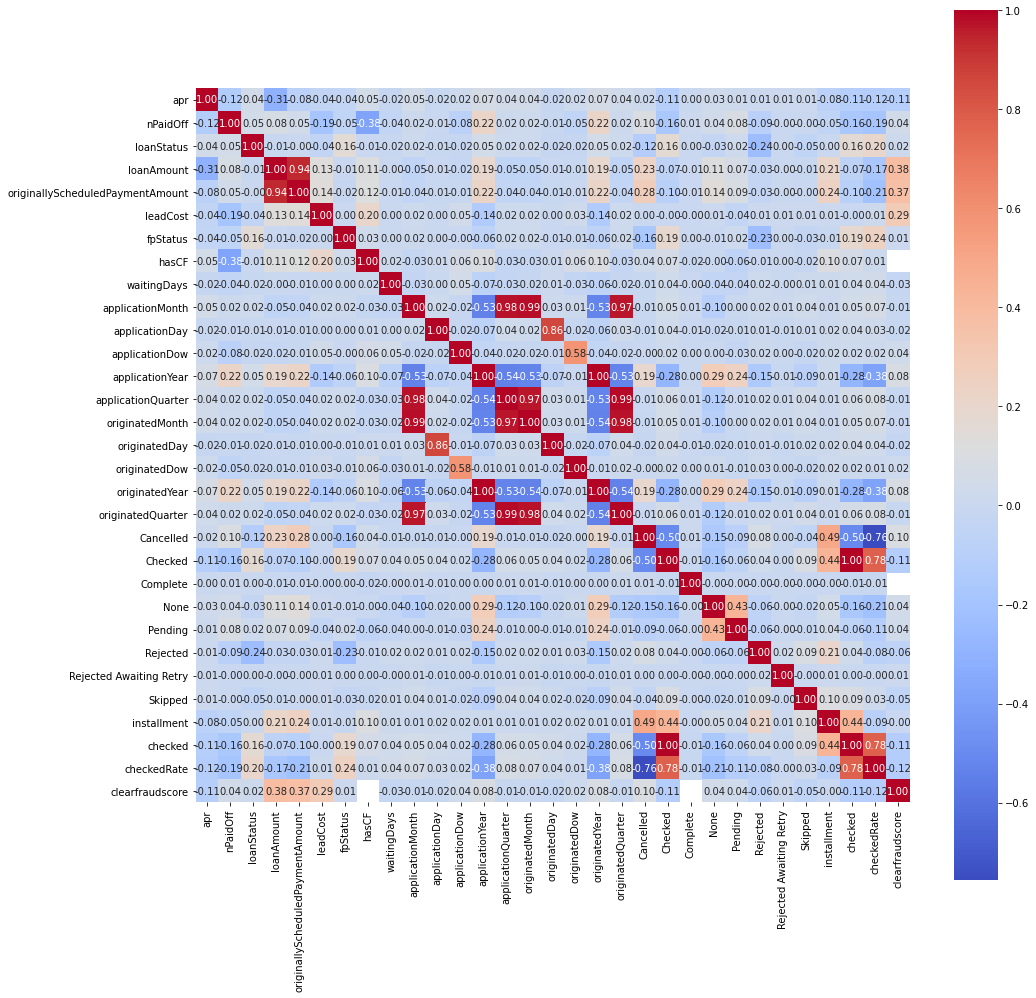

In [36]:
plt.figure(figsize = (16,16))
sns.heatmap(df.drop(['originated', 'approved', 'isFunded', 'Returned'], axis=1).corr(), annot=True, cmap='coolwarm', square=True, fmt='.2f')
plt.show()

##### Impute clearfraudscore

In [37]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer

In [38]:
columns = ['loanAmount', 'leadCost', 'clearfraudscore']
fill = df[columns]
fill.isnull().sum()

loanAmount            0
leadCost              0
clearfraudscore    2634
dtype: int64

In [39]:
# imputer = IterativeImputer(random_state=42)
imputer = KNNImputer(n_neighbors=2)
imputer.fit(fill)
filled = imputer.transform(fill)
# imputer.n_iter_

In [40]:
filled = pd.DataFrame(filled, columns=columns)
filled.isnull().sum()

loanAmount         0
leadCost           0
clearfraudscore    0
dtype: int64

In [41]:
filled.compare(fill)

clearfraudscore      
                 self other
4               585.0   NaN
16              828.5   NaN
25              728.5   NaN
31              823.0   NaN
40              731.0   NaN
...               ...   ...
12588           585.0   NaN
12597           823.0   NaN
12606           823.0   NaN
12611           731.0   NaN
12616           854.0   NaN

[2634 rows x 2 columns]

In [42]:
df[columns] = filled

In [43]:
# remove unwanted columns
df = df.drop(['loanId', 'anon_ssn', 'underwritingid', 'clarityFraudId', 'approved', 'isFunded'], axis=1)
# one hot encoding
df = pd.get_dummies(df, columns=['payFrequency', 'state', 'leadType'])
df = df.fillna(0)
df.head()

,apr,originated,nPaidOff,loanStatus,loanAmount,originallyScheduledPaymentAmount,leadCost,fpStatus,hasCF,waitingDays,...,leadType_bvMandatory,leadType_california,leadType_express,leadType_instant-offer,leadType_lead,leadType_lionpay,leadType_organic,leadType_prescreen,leadType_rc_returning,leadType_repeat
0,199.0,1,0.0,1.0,3000.0,6395.19,0.0,1,1,0.74,...,0,0,0,0,0,0,0,1,0,0
1,490.0,1,2.0,1.0,1250.0,3313.78,0.0,1,1,0.01,...,0,0,0,0,0,0,1,0,0,0
2,590.0,1,0.0,1.0,800.0,2432.08,10.0,1,1,2.25,...,1,0,0,0,0,0,0,0,0,0
3,404.1,1,3.0,1.0,300.0,422.64,0.0,1,1,0.50,...,0,0,0,0,0,0,1,0,0,0
4,590.0,1,0.0,1.0,300.0,896.87,6.0,0,0,0.07,...,1,0,0,0,0,0,0,0,0,0


In [44]:
df.to_pickle("input.pickle")